# Solutions to Problem Sheet 7 - Q6

In this problem, we will solve a reaction-diffusion system. 

--- 

Reaction-diffusion systems are commonly used to model systems of diffusing chemical species which can interact with each other. We have seen in the last lecture that under the right conditions diffusion can surprisingly lead to the emergence of patterns (i.e. stable, time-independent, spatially heterogeneous solutions) in a system which would be in a stable uniform steady-state in the absence of diffusion! 

This is exemplified even in simple reaction-diffusion systems like the Gierer-Meinhardt model (1972) which has been used to explain morphogenesis and patterns in developmental biology. The Gierer-Meinhardt model is an activator-inhibitor system in which two chemical species with concentration $u$ and $v$ diffuse and interact according to the following system of PDEs
$$
\begin{aligned}
&\frac{\partial u}{\partial t} = D_u \frac{\partial^2 u}{\partial x^2} + \frac{u^2}{v} - bu \\
&\frac{\partial v}{\partial t} = D_v \frac{\partial^2 v}{\partial x^2} + u^2 - v 
\end{aligned}
$$
where $D_u$ and $D_v$ are the respective diffusivities and $b$ is a free parameter of the model. We will solve this problem on the interval $[0,L]$. We will use periodic boundary conditions, i.e. that $u(0,t) = u(L,t)$.

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib
import matplotlib.pyplot as plt
from math import pi

First, let's try to write an implicit scheme for this problem. We will consider that our domain is discretized with grid points $x_i = i \Delta x$, $\Delta x = L/N$. For all grid points, we write 
$$
\begin{aligned}
\frac{u_{i,n+1} - u_{i,n}}{\Delta t} = D_u \frac{u_{i+1,n+1} - 2u_{i,n+1} + u_{i-1,n+1}}{(\Delta x)^2} + \frac{u_{i,n+1}^2}{v_{i,n+1}} - b u_{i,n+1} \\
\frac{v_{i,n+1} - v_{i,n}}{\Delta t} = D_v \frac{v_{i+1,n+1} - 2v_{i,n+1} + v_{i-1,n+1}}{(\Delta x)^2} + u_{i,n+1}^2 -v_{i,n+1} \\
\end{aligned}
$$

In doing so, you quickly realize that because the PDE is nonlinear, you will not be able to recast this set of equation in a simple matrix form. Actually, the nonlinear terms on the right-hand side of the equations are evaluated at timestep $n+1$ and would require you to solve a nonlinear system of equations which is complicated and usually done iteratively. As we have not seen this at all in this module, we should look for a different solution. 

If the nonlinear terms on the RHS of the equation were evaluated at timestep $n$ instead, the problem would be much easier! This approximation is commonly done and makes your numerical scheme semi-implicit. By doing so, you change your discrete set of equations to 
$$
\begin{aligned}
\frac{u_{i,n+1} - u_{i,n}}{\Delta t} = D_u \frac{u_{i+1,n+1} - 2u_{i,n+1} + u_{i-1,n+1}}{(\Delta x)^2} + \frac{u_{i,n}^2}{v_{i,n}} - b u_{i,n} \\
\frac{v_{i,n+1} - v_{i,n}}{\Delta t} = D_v \frac{v_{i+1,n+1} - 2v_{i,n+1} + v_{i-1,n+1}}{(\Delta x)^2} + u_{i,n}^2 -v_{i,n} \\
\end{aligned}
$$
which you can rewrite as 
$$
\begin{aligned}
-\alpha u_{i+1,n+1} +(1+ 2\alpha) u_{i,n+1} - \alpha u_{i-1,n+1} = u_{i,n}+ \Delta t\left(\frac{u_{i,n}^2}{v_{i,n}} - b u_{i,n}\right) \\
-\beta v_{i+1,n+1} +(1+ 2\beta) v_{i,n+1} - \beta v_{i-1,n+1} = v_{i,n}+ \Delta t\left(u_{i,n}^2 -v_{i,n}\right) \\
\end{aligned}
$$
where we have defined $\alpha = D_u \Delta t/(\Delta x)^2$ and $\beta = D_v \Delta t/(\Delta x)^2$. Here, we are imposing periodic boundary conditions (not Dirichlet or Neumann boundary conditions); we conclude that this numerical scheme can be written in matrix form as 
$$
\begin{aligned}
A \mathbf{u}_{n+1} = \mathbf{u}_n + \Delta t \mathbf{a}_n \\
B \mathbf{v}_{n+1} = \mathbf{v}_n + \Delta t \mathbf{b}_n
\end{aligned}
$$
where we have defined 
$$
A = \begin{pmatrix}
1+2\alpha & -\alpha & 0  & 0  & -\alpha \\
-\alpha & 1+2\alpha & -\alpha & 0  & 0 \\
0 & -\alpha & 1+2\alpha  & -\alpha  & 0 \\
0 & 0 &  -\alpha & 1+2\alpha  & -\alpha \\
-\alpha & 0 &  0 & -\alpha  & 1+2\alpha
\end{pmatrix}
$$
and 
$$
B = \begin{pmatrix}
1+2\beta & -\beta & 0  & 0  & -\beta \\
-\beta & 1+2\beta & -\beta & 0  & 0 \\
0 & -\beta & 1+2\beta  & -\beta  & 0 \\
0 & 0 &  -\beta & 1+2\beta  & -\beta \\
-\beta & 0 &  0 & -\beta  & 1+2\beta
\end{pmatrix}
$$
Note the difference between these matrices used for periodic boundary conditions and the matrix in Q4. Let us implement this numerical method! 

In [2]:
def gierer_meinhardt(par):
    # Semi-implicit scheme with periodic boundary conditons for the Gierer-Meinhardt reaction diffusion system
    # This function takes as input: 
    # - par: a class containing the parameters of the simulation
    # It returns
    # - us: 2D array containing the solution surface
    # - xs: 1D array containing the location of the grid points
    # - ts: 1D array containing the value of the times at which the solution is available
    
    # Domain definition
    xmin = par.xmin 
    xmax = par.xmax
    T = par.T
    Du = par.Du
    Dv = par.Dv
    bc = par.bc

    # Number of discretization points in space and time
    Nx = par.Nx
    Nt = par.Nt

    # Spatial and temporal step size
    dx = (xmax-xmin)/(par.Nx-1)
    dt = T/(par.Nt-1)

    # Prepare the data structure
    ts = np.linspace(0,T,Nt)
    xs = np.linspace(xmin,xmax,Nx)
    us = np.zeros((len(xs),len(ts)))
    vs = np.zeros((len(xs),len(ts)))

    # Initialize the system with initial conditions
    us[:,0] = par.u0
    vs[:,0] = par.v0
    u = par.u0
    v = par.v0
    
    # Define matrices
    a = Du*dt/dx**2
    d1 = np.diag(     -a*np.ones(Nx-1),-1)
    d2 = np.diag((1+2*a)*np.ones(Nx  ), 0)    
    d3 = np.diag(     -a*np.ones(Nx-1),+1)
    A = d1 + d2 + d3
    A[0,-1]=-a
    A[-1,0]=-a
    Ainv = inv(A)
    
    b = Dv*dt/dx**2
    d1 = np.diag(     -b*np.ones(Nx-1),-1)
    d2 = np.diag((1+2*b)*np.ones(Nx  ), 0)    
    d3 = np.diag(     -b*np.ones(Nx-1),+1)
    B = d1 + d2 + d3
    B[0,-1]=-b
    B[-1,0]=-b
    Binv = inv(B)
    
    # For loop over time to advance the solution 
    for iT in range(1,Nt):
        # Reaction terms
        f = u**2/v - bc*u
        g = u**2 - v
        # Solve linear system
        u = np.matmul(Ainv,u+dt*f)
        v = np.matmul(Binv,v+dt*g)
        us[:,iT] = u
        vs[:,iT] = v
        
    return xs,ts,us,vs

Here, we solve the Gierer-Meinhardt model with $b = 0.35$, $D_u = 1$ and $D_v = 50$. We will use the following initial conditions $u(x,0) = 1/b + \eta(x)$ and $v(x,0) = 1/b^2$, where $\eta$ is a noise with amplitude $0.01$. We will use a domain size $L=80$ and a number of grid points $N=500$; we will use a time step $\Delta t =1$.

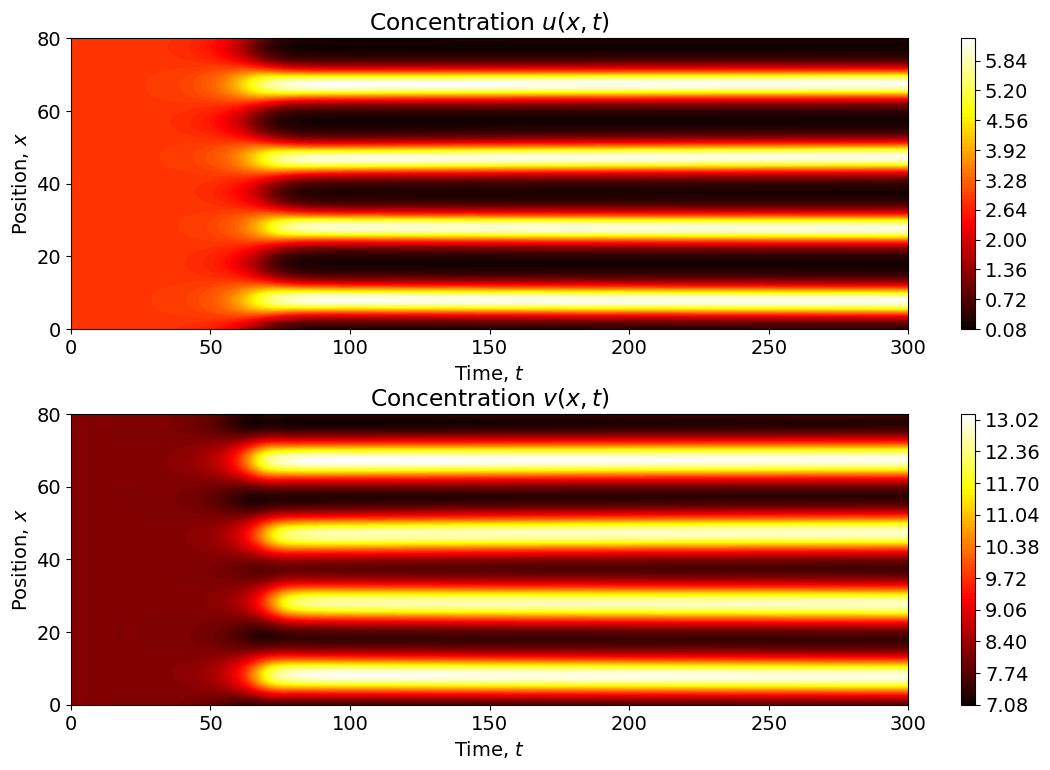

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

font = {'size'   : 14}
matplotlib.rc('font', **font)

# Create an empty class to contain our parameters
class params:
    pass

par = params()
par.xmin = 0
par.xmax = 80
par.T = 300
par.Du = 1
par.Dv = 50
par.bc = 0.35
par.Nx = 500
par.Nt = 301
par.u0 = 1/par.bc*np.ones(par.Nx) + 0.01*np.random.rand(par.Nx)
par.v0 = 1/par.bc**2*np.ones(par.Nx)

# Solve the problem with finite differences 
xs,ts,us,vs=gierer_meinhardt(par)

# Plot the solution
fig1, (ax1,ax2) = plt.subplots(2)
fig1.tight_layout(pad=2.5)
T, X = np.meshgrid(ts, xs)

c1 = ax1.contourf(T, X, us, 100, cmap ="hot")
cbar1 = fig1.colorbar(c1,ax=ax1)

ax1.set_title(r'Concentration $u(x,t)$')
ax1.set_ylabel(r'Position, $x$')
ax1.set_xlabel(r'Time, $t$')

c2 = ax2.contourf(T, X, vs, 100, cmap ="hot")
cbar2 = fig1.colorbar(c2,ax=ax2)

ax2.set_title(r'Concentration $v(x,t)$')
ax2.set_ylabel(r'Position, $x$')
ax2.set_xlabel(r'Time, $t$')

plt.show()

We can clearly see that under these conditions, the concentration fields developed patterns at long times! Let's visualize the solution differently.

<IPython.core.display.Javascript object>


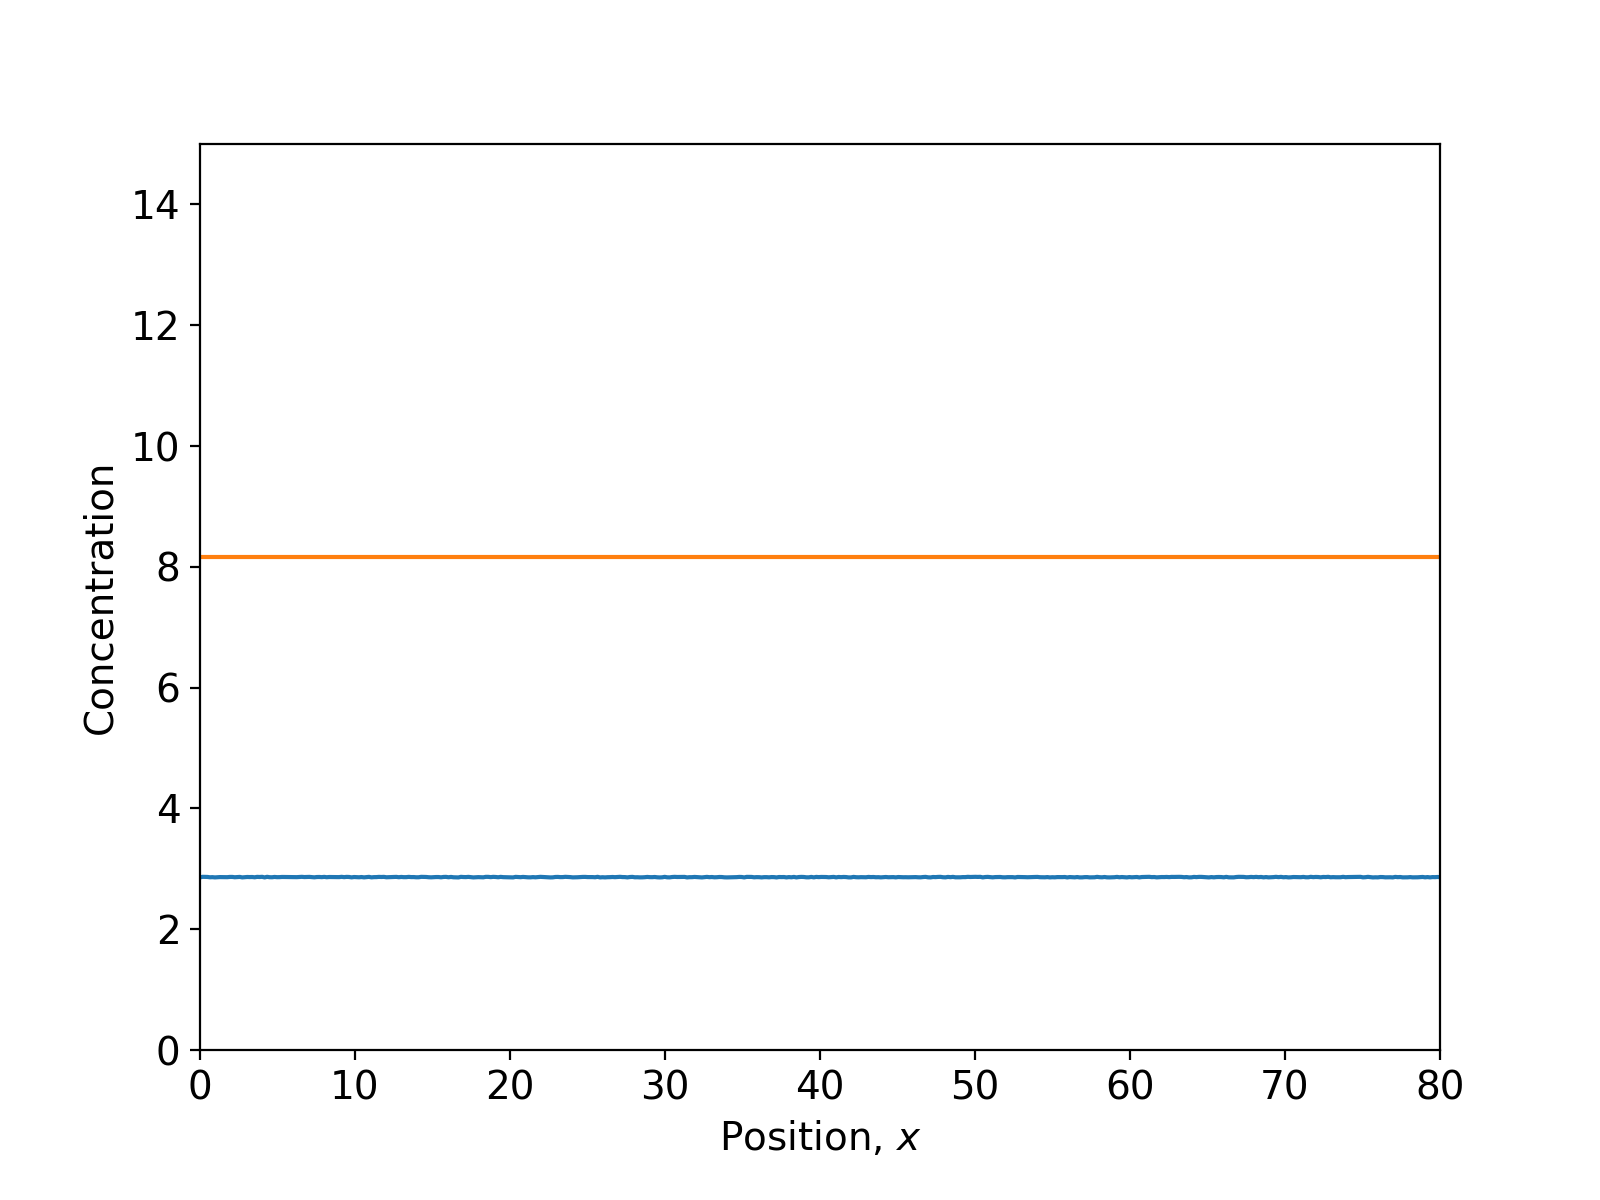

interactive(children=(IntSlider(value=0, description='Time', layout=Layout(width='500px'), max=300), Output())…

In [4]:
%matplotlib notebook
from ipywidgets import Layout, interact, IntSlider
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

font = {'size'   : 14}
matplotlib.rc('font', **font)

# Careful this snippet of code requires the solution, execute first the previous code block
fig2 = plt.figure()
ax = fig2.add_subplot(1, 1, 1)
line1, = ax.plot(xs, us[:,0], label='$u(x,t)$')
line2, = ax.plot(xs, vs[:,0], label='$v(x,t)$')
ax.set_xlabel(r'Position, $x$')
ax.set_ylabel(r'Concentration')
ax.set_ylim((0,15))
ax.set_xlim((0,80))
    
def update(Time = 0):
    line1.set_ydata(us[:,Time])
    line2.set_ydata(vs[:,Time])
    fig2.canvas.draw_idle()

interact(update, Time=widgets.IntSlider(min=0, max=len(ts)-1, step=1, value=0,layout=Layout(width='500px')));